# Anisotropy

See Olsthoorn, H2O (1982, Nr. 11, p261, 263-267) "Anisotroie, een verwaarloosd verschijnsel bij grondwatervraagstukken."

The idea is to show aniotropy in figure.

First some exercises, further down the real example.

This is ongoing work


@TO 20251126

In [198]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from matplotlib import patches
from itertools import cycle

## Using Affine2D()

from matplotlib.trasnforms import Affine2D

    . ax.transData            --- from virtual coordinates to normal data coordinates
    . ax.transAxes            --- from virtual coordinates to axes-relative (0 - 1) coordinates
    . ax.transFigure          --- from virtual coordinates to figure-relative (0 - 1)
    . ax.transDta.inverted()  --- from virtual coordinates to convert from display back to data

### Transform data coordinates to display (pixel) coordinates

xdata, ydata = 1.2, 0.7
xdisp, ydisp = ax.transData.transform((xdata, ydata))

### Transform diplay (pixel) coordinates back to data coordinates

xdata2, ydata2 = ax.transData.inverted().transform((xdisp, ydisp))

### Round trip

assert (xdata, ydata) == (xdata2, ydata2)

Affine2D().scale(sx, sy)
Affine2D().rotate(theta)
Affine2D().rotate_deg(deg)
Affine2D().shear(shx, shy)
Affine2D().skew_deg(shx, shy)
Affine2D().translate(tx, ty)

### Concatenate transforms using the dot

rotations, scaling, translation etc.

T = Affine2D().rotate(alpha).scale(sx, sy).translate(tx, ty)

### Use method transform to apply the transform to data coordinates in figure

ax.transData yields pixel coordinates of the screen, seldom interesting for the user.

T = T + ax.transData
xy_new = T.transform(xy_old)

In [201]:
# --- Affine2D has a 41 usable attributes
# [p for p in dir(Affine2D) if not p.startswith('_')]

In [200]:
# help(Affine2D().translate)
# help(Affine2D().transform)

In [ ]:

def arrow(xy, dxy, ax=None, transform=None, **kwargs):
    """
    Draw a proper arrow with optional affine transform.
    Keeps arrow head size stable and updates axes limits.
    
    The orignal arrow method is not always stable, so annotate
    is wrapped to provide a stable angle.

    
    Usage
    -----
    fig, ax = plt.subplots()
    for angle in np.linspace(0, 330, 11):
        t = Affine2D().rotate_deg(angle) # + ax.transData
        arrow((1, 1), (2, 0.5), ax=ax, transform=t, color="C0", lw=2)

plt.show()

    """
    ax = ax or plt.gca()
    
    xy  = np.atleast_1d( xy)
    dxy = np.atleast_1d(dxy)

    # --- Base geometry as 2x2 array
    pts = np.array([xy, xy + dxy])

    # --- If a transform is provided, apply it to the data
    if transform is not None:
        pts = transform.transform(pts)

    # --- Autoscale axes to include arrow
    ax.update_datalim(pts)
    ax.autoscale_view()

    p0, p1 = pts

    return ax.annotate(
        "",
        xy=p1,
        xytext=p0,
        arrowprops=dict(
            arrowstyle="-|>",   # fixed-size arrow head
            shrinkA=0,
            shrinkB=0,
            linewidth=1.0,
            **kwargs
        )
    )


def perpendicular_vector(P, A, B):
    """Return vector d perpendicular to line through points A and B and hitted point F."""
    P = np.asarray(P)
    A = np.asarray(A)
    B = np.asarray(B)

    v = B - A               # line direction
    w = P - A

    t = np.dot(w, v) / np.dot(v, v)
    F = A + t * v           # foot point
    d = F - P               # perpendicular vector (from P to line)

    return d, F


In [ ]:
def shift(dx, dy):
    """Return an affine translation"""
    return Affine2D().translate(dx, dy)

def rotation_around_center(angle, center=(0, 0)):
    """Return an Affine2D rotation around an arbitrary point."""
    cx, cy = center
    return (Affine2D()
            .translate(-cx, -cy)
            .rotate_deg(angle)
            .translate(cx, cy))


fig, ax = plt.subplots()

xy = np.array([[0., 0.], [-1., 1.], [0, 2] ,[-0.5, 1] ,[0, 0]])
center = (1, 1)
ax.set(title=f"Rotation around center ({center[0]}, {center[1]})", xlabel='x', ylabel='y')
ax.plot(*center, 'ro')
for angle in np.linspace(0, 333, 11):
    rot = rotation_around_center(angle, center=center)
    p = patches.Polygon(xy, fc='yellow', ec='black')
    p.set_transform(rot + ax.transData)
    ax.add_patch(p)

ax.autoscale()

## Example of use of Affine2D

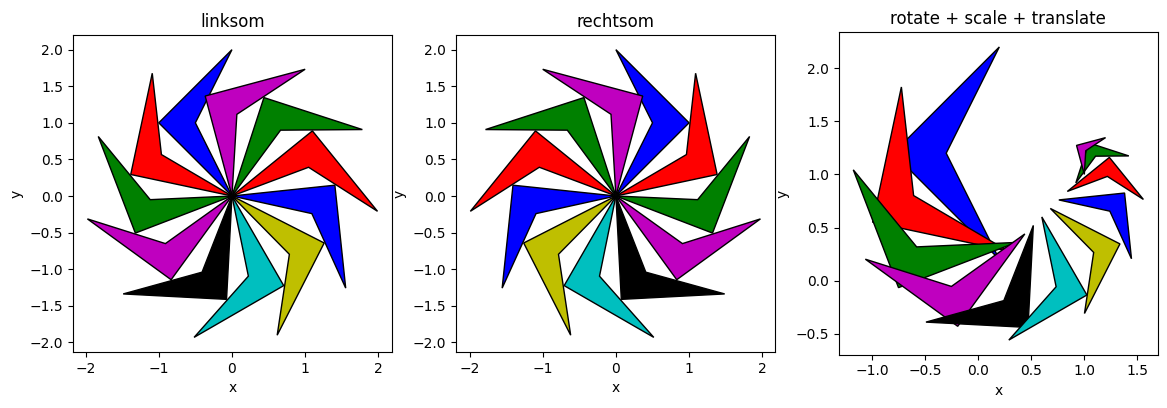

In [227]:
def update_datalim(patch, ax):
    """Update the ax.datalim for autoscaling."""
    path = patch.get_path()
    trans = patch.get_patch_transform()
    verts = trans.transform(path.vertices)
    ax.update_datalim(verts)

# --- shape (sikkel)
xyR = np.array([[0., 0.], [1., 1.], [0, 2] ,[0.5, 1] ,[0, 0]])
xyL = np.array([[0., 0.], [-1., 1.], [0, 2] ,[-0.5, 1] ,[0, 0]])

# --- show it
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,  figsize=(14, 7))

ax1.set(title='linksom',  xlabel='x', ylabel='y')
ax2.set(title='rechtsom', xlabel='x', ylabel='y')
ax3.set(title='rotate + scale + translate', xlabel='x', ylabel='y')

# ax1.plot(*xyL.T)
# ax2.plot(*xyR.T)
# ax3.plot(*xyL.T)

# --- rotate it
clrs = cycle('brgmkcy')
for alpha, s, t in zip(np.linspace(0, 330, 11), np.linspace(1, 0.2, 11), np.linspace(0.2, 1, 11)):
    clr = next(clrs)
    
    # --- rotate clockwise
    trL = Affine2D().rotate_deg(alpha)
    pL = patches.Polygon(xyL, fc=clr, ec='black')
    pL.set_transform(trL + ax1.transData)
    
    # --- rotate anti-clockwise
    trR = Affine2D().rotate_deg(-alpha)
    pR = patches.Polygon(xyR, fc=clr, ec='black')
    pR.set_transform(trR + ax2.transData)
    
    # --- rotate, scale and translate
    tr = Affine2D().rotate_deg(alpha).scale(s, s).translate(t, t)
    p = patches.Polygon(xyL, fc=clr, ec='black')
    p.set_transform(tr + ax3.transData)
    
    # --- update datalim of the axes
    update_datalim(pL, ax1)
    update_datalim(pR, ax2)
    update_datalim(p,  ax3)

    # --- add the patches
    ax1.add_patch(pL)
    ax2.add_patch(pR)
    ax3.add_patch(p)
        
# --- apply autoscale, without it the xlim and ylim are still 0-1
ax1.autoscale_view()
ax2.autoscale_view()
ax3.autoscale_view()
    
# --- keep axes the same
ax1.set_aspect(1.0)
ax2.set_aspect(1.0)
ax3.set_aspect(1.0)

fig.savefig(os.path.join(os.getcwd(), '../images', 'test_affine.png'))


## Example working towards anisotropy

Anisotropic case in 2D of a well near a canal, where the main conductivity axes make an angle of 40 deg with the map axes. The first image is the map, the second shows the map rotated to align with the horizontal and vertical axes (new map, say).The third image shows the scaling such that the conductivities become the same in both direction and the problem will be isotropic. The coordinates of the mirror well are computed to place this mirror well. The drawdown by well and  mirror well are computed on a grid in the istropic map. Then the contours of the drawdown are computed. Back-transformation of uses the coordinates of the contours, obtained from Cs.get_paths(). It also uses their level form Cs.levels and their edgecolors form cs.edgecolor or cs.ec. Transforms these back to the seond and then to the first image and plots them using the same colors as the original isotropic contour lines in image #3.

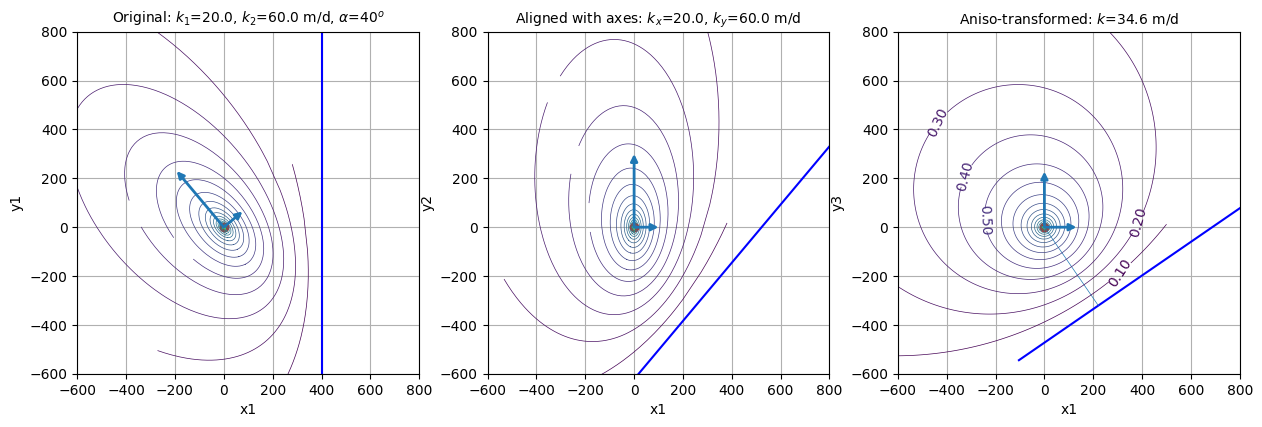

In [ ]:
well = np.array([0., 0.])
shore = np.array([[400, -600], [400, 800]])
alpha = 40
kx, ky = 20., 60.
D, rw = 30., 0.25
k = np.sqrt(kx * ky)

# --- define arrows lenghts do denote the axes direction
xax = np.array([[0, 0],[1, 0]]) * kx * 5
yax = np.array([[0, 0],[0, 1]]) * ky * 5

# --- Align with the anisotropy's main conductivity axes
xax = Affine2D().rotate_deg(alpha).transform(xax)
yax = Affine2D().rotate_deg(alpha).transform(yax)


# --- Plot three consequtive axes to show original, rotated and stretched situations
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 8))

# --- Loop over the three axes concatenating rotation and scaling using three sets of parameters
for i, (ax, angle, (kx_, ky_), title, xlabel, ylabel) in enumerate(zip((ax1, ax2, ax3),
                                              (0, alpha, alpha),
                                              ((1, 1), (1, 1), (kx, ky)),
                                              (fr"Original: $k_1$={kx}, $k_2$={ky} m/d, $\alpha$={alpha}$^o$",
                                               fr"Aligned with axes: $k_x$={kx}, $k_y$={ky} m/d",
                                               fr"Aniso-transformed: $k$={k:.1f} m/d"
                                               ),
                                              ('x1', "x1", "x1"),
                                              ('y1', "y2", "y3"),
                                              )):
    k_ = np.sqrt(kx_ * ky_)
    
    # ---  Affine transformation without ax.transData
    tr = Affine2D().rotate_deg(-angle).scale(np.sqrt(k_ / kx_), np.sqrt(k_ /ky_))
        
    ax.set_title(title,   fontsize=10)
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    
    ax.grid(True)

    ax.plot(*well,    'ro', transform=tr + ax.transData)
    ax.plot(*shore.T, 'b-', transform=tr + ax.transData)
    
    
    # ax.plot(*xax.T, 'r',    transform=tr + ax.transData)
    # ax.plot(*yax.T, 'g',    transform=tr + ax.transData)
    
    # --- The axes arrows without ax.transData
    arrow(xax[0], xax[1], ax=ax, transform=tr, color="C0", lw=2)
    arrow(yax[0], yax[1], ax=ax, transform=tr, color="C0", lw=2)
        
    ax.set_aspect(1.)
    ax.set_xlim(-600, 800)
    ax.set_ylim(-600, 800)

# --- Point perpendicular to the shore line in the isotropic situation
k =np.sqrt(kx_* ky_)
shore_iso = Affine2D().rotate_deg(-alpha).scale(np.sqrt(k / kx), np.sqrt(k /ky)).transform(shore)
d, F = perpendicular_vector(well, *shore_iso)

# --- plot the line from the well to the point perpendicular to the shore
ax3.plot(*np.vstack((well, F)).T, lw=0.5)

# --- In the isotropic axes construct the drawdown and the contour lines
Q, kD = 2400, k_ * D
P1 = (0, 0)
well_mirror = well + 2 * d

# --- Points to compute the drawdown
x = np.linspace(-700, 500, 121)
y = np.linspace(-600, 800, 141)
X, Y = np.meshgrid(x, y)

# --- Distance from these grid points to the wells
r1 = np.fmax(np.sqrt((X - well[       0]) ** 2 + (Y - well[       1]) ** 2), rw)
r2 = np.fmax(np.sqrt((X - well_mirror[0]) ** 2 + (Y - well_mirror[1]) ** 2), rw)

# --- The drawdown
s = Q / (2 * np.pi * kD) * np.log(r2 / r1)

# --- Contour the drawdown
levels = np.linspace(0, 3, 31)[1:]
Cs = ax3.contour(X, Y, s, levels=levels, linewidths=0.5)
ax3.clabel(Cs, levels=Cs.levels[:5], fmt='%.2f')

# --- Plot the drawdown on the previous axes through back-transformations
for path, level , ec in zip(Cs.get_paths(), Cs.levels, Cs.get_ec()):          # each level
    v = path.vertices                  # (n, 2) array of points
    if len(v) > 0:
        v2 = Affine2D().scale(np.sqrt(kx / k), np.sqrt(ky / k)).transform(v)
        ax2.plot(*v2.T, color=ec, lw=0.5)
        
        v3 = Affine2D().rotate_deg(alpha).transform(v2)
        ax1.plot(*v3.T, color=ec, lw=0.5)

os.path.isdir(os.path.join(os.getcwd(), 'images'))
fig.savefig(os.path.join(os.getcwd(), '../images', 'anisotropy.png'))

# Voorbeeld 2

Lijnsegment met vaste totale flow $Q$ en specifieke flux $Q / L$.

We beginnen met $\Omega$, want die kennen we van te voren in, $\Psi$ van $-Q/2$ tot $+Q/2$ hoirzontal, imaginaire as. En $\Phi$ $0\to Q$ reele as.

Schalen naar verticale Psi lijnen tussen -\pi/2 en +door eerst roteren en dan delen door Q en vermenigvuldigen met $\pi$ zodat de lijn Omega = $-i Q/2$ -- $i Q/2$ tussen -\pi/2 en $+/pi/2$ komt te liggen.

$$z = \frac L 2 \sin(i \Omega \pi / Q)$$

$$\Omega = - i \frac Q \pi \arcsin\left(2 \frac z L\right)$$

In [229]:
import numpy as np
import matplotlib.pyplot as plt

In [265]:
def om_fr_z(z, Q=None, L=None):
    return -1j * Q / np.pi * np.arcsin(2 * z / L + 0 * 1j)

def z_fr_om(om, Q=None, L=None):
    return L / 2 * np.sin(1j * om * np.pi / Q)
    
def complex(x=None, y=None):    
    X, Y = np.meshgrid(x, y)
    return X + 1j * Y


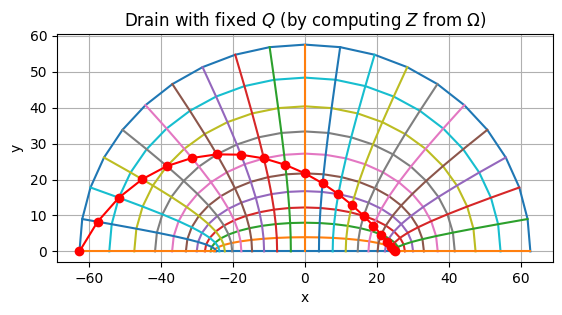

In [282]:
## Lijnelement met vaste q erlangs

# Oplossing via complex transformatie
L = 50.
Q = 10

psi = Q / 2 * np.linspace(-1, 1, 21)
phi = Q * np.linspace(0, 0.5, 11)
Phi, Psi = np.meshgrid(phi, psi)
Omega = Phi + 1j * Psi

Z = np.sin(1j * Omega * np.pi / Q) / 2 * L

fig, ax = plt.subplots()
ax.set(title=r"Drain with fixed $Q$ (by computing $Z$ from $\Omega$)", xlabel='x', ylabel='y')
ax.plot(Z.real, Z.imag)
ax.plot(Z.real.T, Z.imag.T)
ax.grid(True)
ax.set_aspect(1.0)

# --- Specfy values of Omega and show where these points lie in the z-plane
O = np.linspace(0, 0.5 * Q, 21) + 1j * np.linspace(-0.5 * Q, 0.5 * Q, 21)
z = z_fr_om(O, Q=Q, L=L)
ax.plot(z.real, z.imag, 'ro-', label='points')

## A linesink through points $z_1$ and $z_2$

We have the basic linesink between $z=\pm L/2$. What we do now is the  project the ends of the linsink ($z_1$ and $z_2$) to those point of the basic  line sink. For that the $\Omega$ is computed. This $\Omega$ is then used to contour at the orignal Z values (untransformed).

Notice that $\Omega = \Phi + i \Psi$ where the potential $\Phi = k \phi$ with $\phi$ the head.

In [ ]:
def get_pq(z1, z2):
    """Return p and q which map z1 and z2 to -L/2 and L/2."""
    L = np.abs(z1 - z2)
    D = z1 - z2
    p = -L / D
    q = 0.5 * (z1 + z2) * L / D
    return p, q
    
def linesink(Z, z1=None, z2=None, Q=None):
    """Return omega cause by line sink between z1 and z2 injecting Q.
        
    Parameters
    ----------
    Z: coordinates (complex number)
        Locations where Omega is to be computed.
    z1: complex number
        location of one end of the line sink
    z2: complex number
        location of the other end of the line sink.
    Q: real number
        total injection/extraction of the line sink

    Return
    ------
        Omega: comples numbers
            Phi + i Psi at points Z. The reference Omega is
            the mean of that at the ponts along the linesink.
    """
    L = np.abs(z1 - z2)
    p, q = get_pq(z1, z2)
    Z1 = Z * p + q
    w = om_fr_z(Z1, Q=Q / 2, L=L)
    # -- Prevent jump across Phi=0
    w.real = np.abs(w.real)
    return w

def wellseries(Z, z1, z2, Q, N=20):
    """Return drawdown of line sink simulated by a well series.
    
    Parameters
    ----------
    Z: coordinates (complex number)
        Locations where Omega is to be computed.
    z1: complex number
        location of one end of the line sink
    z2: complex number
        location of the other end of the line sink.
    Q: real number
        total injection/extraction of the line sink
    N: int
        Number of well to divide de line sink into.

    Return
    ------
        Omega: comples numbers
            Phi + i Psi at points Z. The reference Omega is
            the mean of that at the ponts along the linesink.
        Zw: complex array
            Well locations
        Zp: complex numbers
            locations along linesink between wells of which the average head
            is used as reference head.
    """
    L = z2 - z1
    # --- points along the line sink
    fp = np.linspace(0, 1, N + 1)
    fw = 0.5 * (fp[:-1] + fp[1:])
    
    Zw = z1 + fw * L
    Zp = z1 + fp  * L
    
    # --- drawdown at point due to wells a long line sink trajectory
    s  = np.zeros_like(Z,  dtype=np.complex128)
    sp = np.zeros_like(Zp, dtype=np.complex128)
    for zw in Zw:
        s  += Q / (2 * N * np.pi) * np.log(Z  - zw)
        sp += Q / (2 * N * np.pi) * np.log(Zp - zw)
    # --- take the mean along the line sink as reference head    
    s -= np.mean(sp)    
    return s, Zw, Zp

def trans_z(Z=None, tr=None):
    """Return transform of complex coordinates Z.
    
    Parameters
    ----------
    Z: complex numbers
        Coordinate(s) to transform
    tr: Affine2D transform
        the tranform
    """
    Z = np.atleast_2d(Z)
    xy = np.array([(x, y) for x, y in zip(Z.real.ravel(), Z.imag.ravel())])
    x, y = tr.transform(xy).T
    Ztr = x + 1j * y
    return Ztr.reshape(Z.shape)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


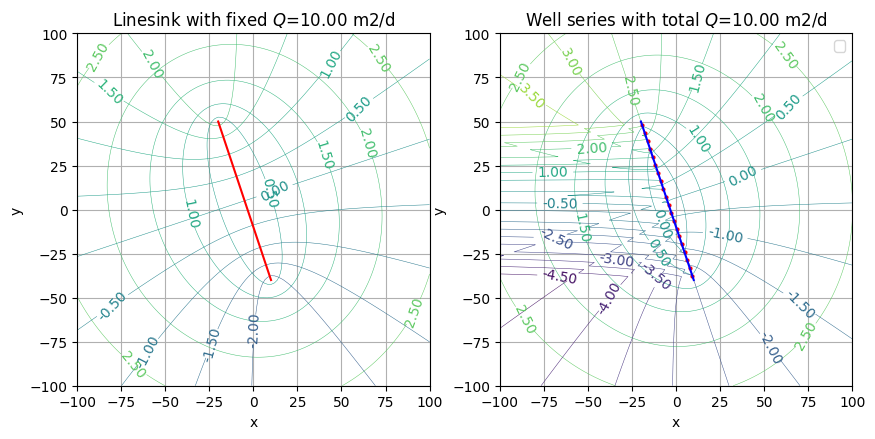

In [376]:

Z = complex(x=np.linspace(-2 * L, 2 * L, 101),
            y=np.linspace(-2 * L, 2 * L, 101))

z1 = -20 + 1j * 50
z2 =  10 - 1j * 40
w1 = linesink(  Z=Z, z1=z1, z2=z2, Q=Q)
w2 = wellseries(Z=Z, z1=z1, z2=z2, Q=Q)

levels=np.linspace(-Q/2, Q/2, 21)

titles = [fr"Linesink with fixed $Q$={Q:.2f} m2/d",
          fr"Well series with total $Q$={Q:.2f} m2/d",
]
funcs = [linesink, wellseries]
          
fig, axs = plt.subplots(1, 2, figsize=(10, 7))
for ax, title, func in zip(axs, titles, funcs):
    
    w = func(Z=Z, z1=z1, z2=z2, Q=Q)

    if isinstance(w, tuple):
        w, zw, zp = w
    else:
        zw, zp = None, None

    ax.set(title=title, xlabel='x', ylabel='y')

    Cs = ax.contour(Z.real, Z.imag, w.real, linewidths=0.35, levels=levels)
    ax.clabel(Cs, levels=Cs.levels, fmt='%.2f')

    Cs = ax.contour(Z.real, Z.imag, w.imag, linewidths=0.35, levels=levels)
    ax.clabel(Cs, levels=Cs.levels, fmt='%.2f')
    
    if zw is not None:
        ax.plot(zw.real, zw.imag, 'ro', ms=2)    
        ax.plot(zp.real, zp.imag, 'b', ms=2)
    else:        
        ax.plot([z1.real, z2.real], [z1.imag, z2.imag], 'r', label='linesink')
    ax.grid(True)
    ax.set_aspect(1)
ax.legend()

# Anisotropy with linesink


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


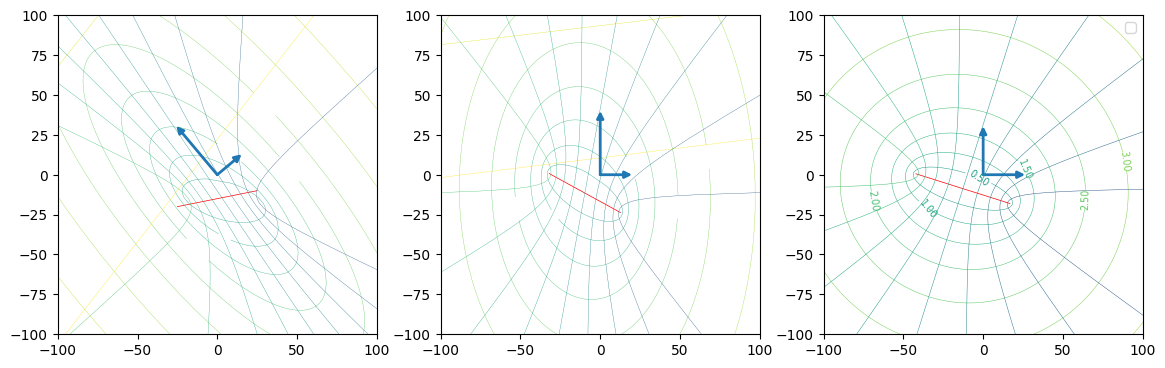

In [ ]:
# --- Data
xac_base = [[0, 0], [20, 0]]
yac_base = [[0, 0], [0, 40]]

alpha = 40

xac_base = Affine2D().rotate_deg(alpha).transform(xac_base)
yac_base = Affine2D().rotate_deg(alpha).transform(yac_base)

k1, k2 = 20., 60.
kx, ky = k1, k2
k = np.sqrt(k1 * k2)

# --- transforms

tr0 = Affine2D().rotate_deg(0)
tr1 = Affine2D().rotate_deg(-alpha)
tr2 = Affine2D().rotate_deg(-alpha).scale(np.sqrt(k / kx), np.sqrt(k / ky))
trs = [tr0, tr1, tr2]

z1_base = -25 - 1j * 20
z2_base = +25 - 1j * 10
p1_base = z1_base.real, z1_base.imag
p2_base = z2_base.real, z2_base.imag
lsink_base = np.array([p1_base, p2_base])

Z_base = complex(np.linspace(-200, 200, 201), np.linspace(-200, 200, 201))

fig, axs = plt.subplots(1, 3, figsize=(14, 7))
for ia, (ax, tr) in enumerate(zip(axs, trs)):    
    # xac = tr.transform(xac_base)
    # yac = tr.transform(yac_base)
    
    # --- The axes arrows without ax.transData
    arrow(xac_base[0], xac_base[1], ax=ax, transform=tr, color="C0", lw=2)
    arrow(yac_base[0], yac_base[1], ax=ax, transform=tr, color="C0", lw=2)

    lsink  = tr.transform(lsink_base)       
    # ax.plot(*xac.T) # , transform=tr + ax.transData)
    # ax.plot(*yac.T) # , transform=tr + ax.transData)
    ax.plot(*lsink.T, 'r-', lw=0.5)
    
    ax.set_aspect(1.0)
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)
    

# --- isotrope medium
tr = tr2
ax = axs[2]
Z = trans_z(Z_base, tr)
w = linesink(Z=Z, z1=trans_z(z1_base, tr), z2=trans_z(z2_base, tr), Q=Q)
w = wellseries(Z=Z, z1=trans_z(z1_base, tr), z2=trans_z(z2_base, tr), Q=Q)

if isinstance(w, tuple):
    w, zw, zp = w
else:
    zw = None
    zp = None

Cs1 = ax.contour(Z.real, Z.imag, w.real, linewidths=0.35, levels=levels)
ax.clabel(Cs1, levels=Cs1.levels, fmt='%.2f', fontsize='x-small')

Cs2 = ax.contour(Z.real, Z.imag, w.imag, linewidths=0.35, levels=levels)
ax.clabel(Cs2, levels=Cs2.levels, fmt='%.2f', fontsize='x-small')
    
ax.legend()

for path, lev, ec in zip(Cs1.get_paths(), Cs1.levels, Cs1.get_ec()):
    if len(path) > 0:
        v2 = path.vertices
        v1 = Affine2D().scale(np.sqrt(kx / k), np.sqrt(ky / k)).transform(v2)
        v0 = Affine2D().scale(np.sqrt(kx / k), np.sqrt(ky / k)).rotate_deg(alpha).transform(v1)
        axs[1].plot(*v1.T, color=ec, lw=0.25)
        axs[0].plot(*v0.T, color=ec, lw=0.25)

for path, lev, ec in zip(Cs2.get_paths(), Cs2.levels, Cs2.get_ec()):
    if len(path) > 0:
        v2 = path.vertices
        v1 = Affine2D().scale(np.sqrt(kx / k), np.sqrt(ky / k)).transform(v2)
        v0 = Affine2D().scale(np.sqrt(kx / k), np.sqrt(ky / k)).rotate_deg(alpha).transform(v1)
        axs[1].plot(*v1.T, color=ec, lw=0.25)
        axs[0].plot(*v0.T, color=ec, lw=0.25)

if zw is not None:
    lsink = trans_z(zw, tr2.inverted())
    ax2.plot(*lsink.T, 'ro', ms=2)
    points = trans_z(zp, tr2.inverted())
    ax2.plot(*points.T, 'b.', ms=2)
    
    lsink = tr1.inverted().transform(lsink)
    ax2.plot(*lsink.T, 'ro', ms=2)
    points = trans_z(zp, tr2.inverted())
    ax2.plot(*points.T, 'b.', ms=2)
else:
    lsink2 = tr2.transform(lsink_base)    
    axs[2].plot(*lsink2.T, 'r-', lw=0.5, label='linesink')

    lsink1 = tr1.transform(lsink_base)    
    axs[1].plot(*lsink1.T, 'r-', lw=0.5, label='linesink')
    
    lsink0 = tr1.transform(lsink_base)    
    axs[0].plot(*lsink0.T, 'r-', lw=0.5, label='linesink')


ax.grid(True)
ax.set_aspect(1)
    
    

fig.savefig(os.path.join(os.getcwd(), '../images', 'anisotropy_linsink.png'))